<a href="https://colab.research.google.com/github/shuwenericlei/be183/blob/main/HW4_Problem3_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bi/Be/Cs 183 2022-2023: Intro to Computational Biology
TAs: Meichen Fang, Tara Chari, Zitong (Jerry) Wang

**Submit your notebooks by sharing a clickable link with Viewer access. Link must be accessible from submitted assignment document.**

Make sure Runtime $\rightarrow$ Restart and run all works without error

**HW 4 Problem 3**

In this problem you will develop code for running the EM algorithm to fit a Gaussian Mixture Model (GMM). You will learn the mixture weights for a set of (multivariate) Gaussian distributions, which describe the input, single-cell data. This is a common approach to determine clusters within a dataset.


##**Import data and install packages**

In [ ]:
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt #Can use other plotting packages like seaborn

In [ ]:
import time
t=time.time()

In [ ]:
#Download count matrix of cell by gene counts and metadata files, DOI: 10.22002/D1.2315
#tar.gz file which has:
#(1) count matrix 
#(2) metadata for cells (cell type, date of experimental run) 
#(3) metadata for genes (gene names)

import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname

download_file('10.22002/D1.2315','.gz')


<ipython-input-3-6c7d4cfd6c14>:24: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  pbar = tnrange(int(total_length/1024), unit="B")


  0%|          | 0/94578 [00:00<?, ?B/s]

'D1.2315.gz'

In [ ]:
!mv D1.2315.gz biccn.tar.gz
!tar -xvf biccn.tar.gz

biccnGeneMeta.csv
biccnMeta.csv
biccn.mtx


## **Read in data for analysis**

**The dataset**

This dataset maps the cells in the mouse primary cortex (MOp), including neuronal and non-neuronal cell types, for a total of 10 cell types ([Yao et al., 2021](https://www.nature.com/articles/s41586-021-03500-8)). We will be dealing with the 10x sequenced data only.


**The count matrix**

This matrix is 18,744 cells by 5,000 genes. The full dataset contains 71,365 cells, however we will work with a randomly subsetted version to facilitate calculations within the Colab environment.

1.   For each cell, gene counts were normalized to have the same number of total counts (usually 1e5 or 1e6), with cell-gene counts thus scaled accordingly.

2.   Counts were then log-normalized, using the log(1+x), where x is each cell's gene count. The 1 accounts for 0 count genes. 

3. The ~5000 genes were selected for those that displayed large variance in expression amongst the cells ('highly variable genes').



In [ ]:
#Get gene count matrix
count_mat = sio.mmread('biccn.mtx')

count_mat = count_mat.todense() #Make dense since most functions we'll use don't work with sparse matrices
count_mat.shape

(18744, 5000)

In [ ]:
#Get metadata dataframe for the 18,744 cells (rows of the matrix)
meta = pd.read_csv('biccnMeta.csv',index_col = 0)
meta.head()

,cell_type
barcode,
AAACGAAGTGGATTTC-3L8TX_181211_01_A01,L2/3 IT
AAACGCTCAATGCTCA-3L8TX_181211_01_A01,L2/3 IT
AAAGTCCGTGTATCCA-3L8TX_181211_01_A01,L6 CT Cpa6_1
AAAGTGAGTCGCCACA-3L8TX_181211_01_A01,L2/3 IT
AAAGTGATCGTCTACC-3L8TX_181211_01_A01,L2/3 IT


In [ ]:
#Get metadata dataframe for the 5,000 genes (columns of the matrix)

meta_gene = pd.read_csv('biccnGeneMeta.csv',index_col = 0)
meta_gene.head()


,gene_name
Rp1_ENSMUSG00000025900,Rp1_ENSMUSG00000025900
Sox17_ENSMUSG00000025902,Sox17_ENSMUSG00000025902
Oprk1_ENSMUSG00000025905,Oprk1_ENSMUSG00000025905
St18_ENSMUSG00000033740,St18_ENSMUSG00000033740
Sntg1_ENSMUSG00000025909,Sntg1_ENSMUSG00000025909


## **Problem 3 (30 points)**

Gaussian mixture model (GMM) is as defined below:

\begin{align}
f_{GMM}(\mathbf{x})=\sum_{j=1}^k \phi_j f(\mathbf {x};{\boldsymbol{\mu }}_{j},\mathbf{\Sigma}_{j})
\end{align}
subject to $\sum_{j=1}^k \phi_j = 1$.

$\boldsymbol{\phi}$ denotes the weights for each Gaussian pdf $f$, and together the GMM is defined as the weighted sum of these Gaussians. $\boldsymbol{\mu} \text{ and } \mathbf{\Sigma}$ represent the mean (vector) and covariance (matrix) for each of the $k$ multivariate Gaussians. This model can then describe data with multiple modes/areas of high density i.e. $k$ cell types which shared distinct gene expression signatures.

Let $\mathbf{x} = (\mathbf{x}_1, \mathbf{x}_2, \ldots \mathbf{x}_n)$ be $n$ independent observations (e.g. cells) which come from a mixture of Gaussians. They are $d$ dimensional, where $d$ is the number of gene measurements. We will define $\mathbf{z} = (z_1, z_2, \ldots z_n)$ as the latent variable which represents the mixture component (of the $k$ components) which a cell comes from. Thus $\phi_j = P(Z = j)$.

The parameters to be fit, $\theta = (\boldsymbol{\mu}_1,\ldots \boldsymbol{\mu}_k, \mathbf{\Sigma_1}, \ldots \mathbf{\Sigma_k}, \mathbf{\phi}_1, \ldots \mathbf{\phi}_k)$ (the parameters of the GMM).

The (complete) likelihood for maximization is defined as 
\begin{align}
p(\mathbf {x},\mathbf {z};\theta) =\prod _{i=1}^{n}\prod _{j=1}^{k}\ [f(\mathbf {x} _{i};{\boldsymbol{\mu }}_{j},\mathbf{\Sigma}_{j})\phi_{j}]^{\mathbb {I} (z_{i}=j)}
\end{align}

where $\mathbb {I}$ is the indicator function.

As described in Problem 1, we will use the $Q$ function to maximize, where 
\begin{align}
Q(\theta|\theta_t) = E_{\mathbf {z}|\mathbf {x},\theta_t} [\log(p(\mathbf {x},\mathbf {z};\theta))].
\end{align}


Dimensions of variables ($n$ cells, $d$ genes):

$\mathbf{X}: n\times d$ matrix

$\boldsymbol{\mu}: k \times d$ matrix

$\boldsymbol{\Sigma}: k\times d \times d$ matrix

$\boldsymbol{\phi}:$ 1d array of length $k$

### **a) Often covariance matrices of single-cell datasets are singular (non-invertible). Subset the input matrix X to create a 'regularized'-non-singular matrix to use.(5 points)**

Remove the bottom half of genes based on variance i.e. calculate the variance of expression for *each* gene and remove any genes below the mean variance (from across all genes). In this sense we are further removing 'redundancy' from the matrix.

Remember that the counts of the matrix are log1p() of the original counts.

**Report how many genes remain after this subsetting, and use this subsetted matrix for all downstream calculations.**

In [ ]:
ori_counts=np.exp(count_mat)-1

In [ ]:
gene_var=np.ravel(np.var(ori_counts, axis=0))
mean = np.mean(gene_var)
idx = gene_var > mean

counts=count_mat[:,idx]
counts.shape

(18744, 97)

In [ ]:
X=counts

### **b) Implement the E step (5 points)**

For the E step we assume a set of (randomly initialized) $\theta_t$.
Then:
\begin{align}
Q(\theta|\theta_t) &= \sum_{i=1}^{n} \sum_{j=1}^{k} P(Z_i = j | X_i = \mathbf{x}_i; \theta_t) \log(p(\mathbf {x}_i,j;\theta_j)) \\
 &= \sum_{i=1}^{n} \sum_{j=1}^{k} T_{i,j}^t[\log \phi _{j}-{\tfrac {1}{2}}\log |\mathbf{\Sigma} _{j}|-{\tfrac {1}{2}}(\mathbf {x} _{i}-{\boldsymbol {\mu }}_{j})^{\top }\mathbf{\Sigma} _{j}^{-1}(\mathbf {x} _{i}-{\boldsymbol {\mu }}_{j})-{\tfrac {d}{2}}\log(2\pi )]
\end{align}




$T_{i,j}^t$ represents $P(Z_i = j | X_i = \mathbf{x}_i; \theta_t)$ and $p(\mathbf {x}_i,j;\theta_j) = f(\mathbf {x} _{i};{\boldsymbol{\mu }}_{j},\mathbf{\Sigma}_{j})\phi_{j}$.

$T_{i,j}^t$ needs to be calculated given the current $\theta_t$ for every $\mathbf{x}_i$ in the E step.

Using Bayes theorem we can get that 
\begin{align}
T_{i,j}^t = \frac {\phi _{j}^{t}\ f(\mathbf {x} _{i};{\boldsymbol {\mu }}_{j}^{t},\mathbf{\Sigma} _{j}^{t})}{\sum_{r=1}^k \phi _{r}^{t}\ f(\mathbf {x} _{i};{\boldsymbol {\mu }}_{r}^{t},\mathbf{\Sigma} _{r}^{t})}
\end{align}



You can use [scipy.stats multivariate_normal.pdf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html) to calculate $f$ and [numpy cov](https://numpy.org/doc/stable/reference/generated/numpy.cov.html) to calculate covariances.

**Fill in the e_step() function and calculate the matrix $\mathbf{T}$ given inputs $\mathbf{X}, \boldsymbol{\mu^t}, \mathbf{\Sigma^t}, \textbf{ and } \boldsymbol{\phi^t}$. $\mathbf{X}$  represents our cell x genes data matrix.**

Note: You may need to add a small epsilon ($\approx$ 1e-100) to $f$ values, to avoid divide by zero errors.

In [ ]:
from scipy.stats import multivariate_normal

In [ ]:
def e_step(X, Mu, Sigma, phi):
  '''
  Parameters:
   X: n*d matrix
   Mu: k*d matrix
   Sigma: k*d*d tensor
   phi: 1d array of length k
  '''
  eps = 10e-100
  n,d=X.shape 
  k=len(Mu) 
  f = np.zeros((n,k))
  for j in range(k):
    f[:,j] = multivariate_normal.pdf(X, mean=Mu[j], cov=Sigma[j], allow_singular=True)
  f=f+eps
  p=phi[None,:]*f
  T= p/np.sum(p,axis=1)[:,None]
  return T, f

### **c) Implement the M step (5 points)**

In the maximization (M) step, we then (re-)calculate the MLE values for $\theta$ or $(\boldsymbol{\mu}_1,\ldots \boldsymbol{\mu}_k, \mathbf{\Sigma}_1, \ldots \mathbf{\Sigma}_k, \mathbf{\phi}_1, \ldots \mathbf{\phi}_k)$ at this $t+1$ step. 

Here $j$ is from 1 to k.

For $\boldsymbol{\phi}$
\begin{align}
\phi _{j} ={\frac {1}{n}}\sum _{i=1}^{n}T_{i,j}^{t}.
\end{align}


For $\boldsymbol{\mu}$
\begin{align}
\boldsymbol{\mu}_j = \frac{\sum_{i=1}^n T_{i,j}^{t} \mathbf{x}_i}{\sum_{i=1}^n T_{i,j}^{t}}.
\end{align}

And for $\boldsymbol{\Sigma}$
\begin{align}
\mathbf{\Sigma}_j = \frac{\sum_{i=1}^n T_{i,j}^{t} (\mathbf{x}_i - \boldsymbol{\mu}_j)^\top (\mathbf{x}_i - \boldsymbol{\mu}_j) }{\sum_{i=1}^n T_{i,j}^{t}}
\end{align}

**Fill in the m_step() function to calculate the updated $\boldsymbol{\mu}, \mathbf{\Sigma}, \textbf{ and } \boldsymbol{\phi}$ values given $\mathbf{T}$.**

Note: To calculate the new covariance matrices you can use the aweights input option for [np.cov](https://numpy.org/doc/stable/reference/generated/numpy.cov.html), where the $T^t_{i,j}$ values are the weights.

In [ ]:
def m_step(X, T):
  n,d=np.shape(X) 
  n,k=np.shape(T)
  phi = np.mean(T,axis=0)
  Mu = np.zeros((k,d))
  Sigma = np.zeros((k,d,d))
  for j in range(k):
    t = T[:, [j]]
    total_t = t.sum()
    Mu[j,:] = (t.T@X).sum(axis=0) / total_t
    Sigma[j] = np.cov(X.T, aweights=(t/total_t).flatten(), bias=True)
  return Mu, Sigma, phi

### **d) Run EM steps for 100 iterations and get mixture (cluster) assignments for the cells. (10 points)**

To initialize the EM process we will (1) let $k = 10$ (also the number of labeled cell types), (2) assume $\boldsymbol{\phi}$ has a uniform probability for each $k$, (3) choose random rows from the data to represent each of the $k$  $\boldsymbol{\mu}$s, and (4) use the covariance matrix for $\mathbf{X}$ (the cell x genes matrix) to intialize the $k$ $\mathbf{\Sigma}$s.

Run the EM algorithm for 100 iterations.

** **

Determine the final cluster assignment for each cell $i$ by finding which $k$ (mixture component) has the max $T_{i,j}$ value.

**Plot Q over the iterations, and report $\boldsymbol{\phi}$ and the cluster (k) assignments for the first 10 cells after 100 iterations.**

**You can use the initialization provided below.**

In [ ]:
def EM(X, Mu, Sigma, phi, iterations=100):
  Q=np.zeros(iterations)
  old_T, f = e_step(X, Mu, Sigma, phi)
  Mu, Sigma, phi = m_step(X, old_T)
  for i in range(iterations):
    new_T, f = e_step(X, Mu, Sigma, phi)
    q = np.sum(old_T*np.log(phi*f))
    Mu, Sigma, phi = m_step(X, new_T)
    old_T = new_T
    Q[i] = q
  return new_T, Mu, Sigma, phi, Q

In [ ]:
n,d=X.shape
k=10
np.random.seed(2022)
init_idx=np.random.choice(n,k,replace=False)
Mu0=np.asarray(X[init_idx,:])
Sigma0=[ np.cov(X.T) for _ in range(k) ]
phi0=np.ones(k)/k

In [ ]:
T, Mu, Sigma, phi, Q = EM(X, Mu0, Sigma0,  phi0, iterations=100)

In [ ]:
cluster_assig=np.argmax(T, axis=1)

In [ ]:
print("𝜙 is ", phi)

𝜙 is  [0.01916477 0.04064866 0.00914755 0.036432   0.03432795 0.07456357
 0.27759634 0.35443737 0.01313044 0.14055134]


In [ ]:
print("The cluster (k) assignments for first 10 cells are ", cluster_assig[:10])

The cluster (k) assignments for first 10 cells are  [7 7 6 7 7 7 3 5 9 9]


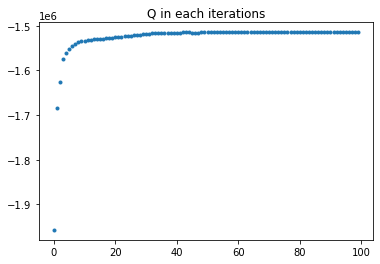

In [ ]:
plt.plot(Q,'.')
plt.title("Q in each iterations")
plt.show()

### **e) Calculate correspondence of generated clusters and given cell type labels. (5 points)**

For each mixture component/cluster of cells, find the majority cell type label and the percent of cells with that label.

**Report the percent of cells with the majority label for each cluster and what that majority label is.**



In [ ]:
lables=cluster_assig
for j in range(k):
    # find cell idx
    cell_idx = np.where(lables==j)[0]
    if len(cell_idx)==0:
      continue
    # count cell type label
    cell_type = meta.iloc[cell_idx]["cell_type"].tolist()
    # find the majority cell type label and percent
    percents=[cell_type.count(x)/len(cell_type) for x in np.unique(cell_type)]
    label_idx = np.argmax(percents)
    print("In the "+ str(j) +"th cluster, " + str(np.around(percents[label_idx],2)) + " of cells have the majority label of " + cell_type[label_idx])

In the 0th cluster, 0.52 of cells have the majority label of Vip Chat
In the 1th cluster, 0.71 of cells have the majority label of L6 CT Cpa6_1
In the 2th cluster, 0.54 of cells have the majority label of Vip Chat
In the 3th cluster, 0.87 of cells have the majority label of L5 NP Slc17a8_1
In the 4th cluster, 0.51 of cells have the majority label of Vip Chat
In the 5th cluster, 1.0 of cells have the majority label of L2/3 IT
In the 6th cluster, 1.0 of cells have the majority label of L6 CT Cpa6_1
In the 7th cluster, 0.98 of cells have the majority label of L2/3 IT
In the 8th cluster, 0.69 of cells have the majority label of Vip Chat
In the 9th cluster, 1.0 of cells have the majority label of L2/3 IT


In [ ]:
t=time.time()-t
print(t/60,'mins')

3.81110733350118 mins


### **Now let's compare to sklearn package (Not in homework)**

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


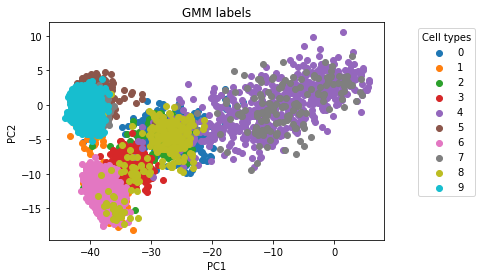

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='full') # if n_components is not set all components are kept
pca.fit(X)

labels=cluster_assig
y_pca = np.array(X@pca.components_.T[:,:2])

fig, ax = plt.subplots()
for i,cell_type in enumerate(np.unique(labels)):
  idx = np.where( labels == cell_type)
  ax.scatter(y_pca[idx,0], y_pca[idx,1], color = list(plt.cm.tab10(i)), label = cell_type)
ax.legend(loc=(1.1,0.2), title="Cell types")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("GMM labels")
plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
gm=GaussianMixture(n_components=k,means_init=Mu0,weights_init=phi0,max_iter=100).fit(X)
gm_clusters=gm.predict(X)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [ ]:
lables=gm_clusters
for j in range(k):
    # find cell idx
    cell_idx = np.where(lables==j)[0]
    # count cell type label
    cell_type = meta.iloc[cell_idx]["cell_type"].tolist()
    # find the majority cell type label and percent
    percents=[cell_type.count(x)/len(cell_type) for x in np.unique(cell_type)]
    label_idx = np.argmax(percents)
    print("In the "+ str(j) +"th cluster, " + str(np.around(percents[label_idx],2)) + " of cells have the majority label of " + cell_type[label_idx])

In the 0th cluster, 1.0 of cells have the majority label of L2/3 IT
In the 1th cluster, 1.0 of cells have the majority label of L6 CT Cpa6_1
In the 2th cluster, 0.61 of cells have the majority label of Vip Chat
In the 3th cluster, 1.0 of cells have the majority label of L2/3 IT
In the 4th cluster, 1.0 of cells have the majority label of Endo Slc38a5_1
In the 5th cluster, 0.47 of cells have the majority label of L5 ET_1
In the 6th cluster, 1.0 of cells have the majority label of Astro Aqp4
In the 7th cluster, 0.58 of cells have the majority label of L5 NP Slc17a8_1
In the 8th cluster, 1.0 of cells have the majority label of L6 CT Cpa6_1
In the 9th cluster, 1.0 of cells have the majority label of L2/3 IT


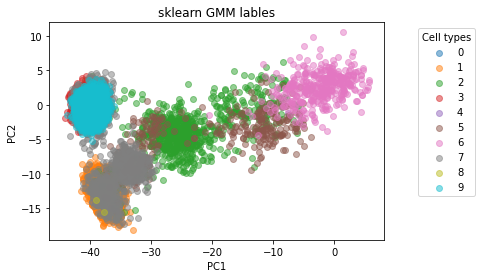

In [ ]:
labels=gm_clusters
y_pca = np.array(X@pca.components_.T[:,:2])


fig, ax = plt.subplots()
for i,cell_type in enumerate(np.unique(labels)):
  idx = np.where( labels == cell_type)
  ax.scatter(y_pca[idx,0], y_pca[idx,1], color = list(plt.cm.tab10(i)), label = cell_type, alpha=0.5)
ax.legend(loc=(1.1,0.2), title="Cell types")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("sklearn GMM lables")
plt.show()

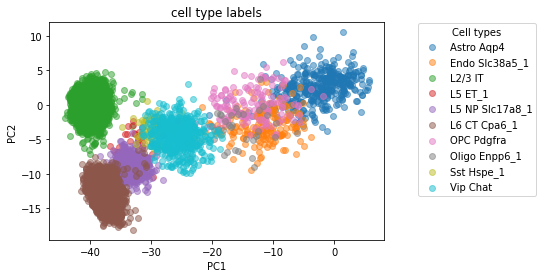

In [ ]:
labels=meta["cell_type"]
y_pca = np.array(X@pca.components_.T[:,:2])

fig, ax = plt.subplots()
for i,cell_type in enumerate(np.unique(labels)):
  idx = np.where( labels == cell_type)
  ax.scatter(y_pca[idx,0], y_pca[idx,1], color = list(plt.cm.tab10(i)), label = cell_type, alpha=0.5)
ax.legend(loc=(1.1,0.2), title="Cell types")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("cell type labels")
plt.show()